In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation, Flatten, Dense, BatchNormalization, ZeroPadding2D
from keras.optimizers import Adam
from keras import backend as k
import tensorflow as tf

import os
import shutil

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/MyDrive/Science Fair/Synopsis Science Fair Project 2021/Dataset_-20210215T213906Z-001.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_/COVID-19/COVID (131).png  
  inflating: Dataset_/COVID-19/COVID (562).png  
  inflating: Dataset_/COVID-19/COVID (627).png  
  inflating: Dataset_/COVID-19/COVID (522).png  
  inflating: Dataset_/COVID-19/COVID (236).png  
  inflating: Dataset_/COVID-19/COVID (174).png  
  inflating: Dataset_/COVID-19/COVID (260).png  
  inflating: Dataset_/COVID-19/COVID (2).png  
  inflating: Dataset_/COVID-19/COVID (165).png  
  inflating: Dataset_/COVID-19/COVID (303).png  
  inflating: Dataset_/COVID-19/COVID (149).png  
  inflating: Dataset_/COVID-19/COVID (16).png  
  inflating: Dataset_/COVID-19/COVID (404).png  
  inflating: Dataset_/COVID-19/COVID (42).png  
  inflating: Dataset_/COVID-19/COVID (38).png  
  inflating: Dataset_/COVID-19/COVID (497).png  
  inflating: Dataset_/COVID-19/COVID (466).png  
  inflating: Dataset_/COVID-19/COVID (469).png  
  inflating: Dataset_/COVID-19/COVID (571).png  
  inflating: Dataset_/C

In [ ]:
# Creates a folder for training and testing sets
!mkdir test
!mkdir train
!mkdir "train/Non-COVID Viral Pneumonia"
!mkdir "train/COVID-19"
!mkdir "train/Normal"
!mkdir "train/Bacterial Pneumonia"
!mkdir "test/Non-COVID Viral Pneumonia"
!mkdir "test/COVID-19"
!mkdir "test/Normal"
!mkdir "test/Bacterial Pneumonia"

In [ ]:
# Divide files into training and testing folders
# IMG_PATH = 'covid19dataset/' # unzipped folder
IMG_PATH = 'Dataset_/' # unzipped folder

print(IMG_PATH)
import os, shutil
# split the data by train/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
      dir  = os.path.isdir(IMG_PATH + CLASS)
      if dir:
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 0.8*IMG_NUM:
                shutil.copy(img, 'train/' + CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'test/'+ CLASS + '/' + FILE_NAME)

Dataset_/


In [ ]:
# dimensions of our images
img_width, img_height = 224, 224
img_size = (224, 224)

# Saving the batch_size and epochs for training to variables
batch_size = 16 #usually in powers of 2 - 8, 16, 32, 64, 128
epochs = 50
lr = 0.0001.
class_array = ['Normal', 'COVID-19', 'Non-COVID Viral Pneumonia']
num_classes = len(class_array)

train_file_count = sum(len(files) for _, _, files in os.walk(r'train'))
test_file_count = sum(len(files) for _, _, files in os.walk(r'test'))

print("Number of files in train set ", train_file_count)
print("Number of files in test set ", test_file_count)

Number of files in train set  6744
Number of files in test set  1684


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, # normalization - tranforms pixel value from 0 - 255 to 0 - 1
                                   validation_split=0.15,
                                   shear_range = 0.2, # extent of shearing - 20%
                                   zoom_range = 0.2, # extent of adjusting the zoom in images - 20%
                                   horizontal_flip= True, # randomly flipping to get mirror images
                                   rotation_range=0.1) # turns the image - 10%

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.15)

In [ ]:
# Create a flow from the directory using same seed and 'training' subset.
train_generator = train_datagen.flow_from_directory('train',
                                              subset='training',
                                              shuffle=True,
                                              seed=42,
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              classes = class_array)

# Create a flow from the directory for validation data - seed=42
validation_generator = valid_datagen.flow_from_directory('train',
                                              subset='validation',
                                              seed=42,
                                              target_size=img_size,
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              classes = class_array)

Found 4136 images belonging to 3 classes.
Found 728 images belonging to 3 classes.


###DenseNet201

In [ ]:
from tensorflow.keras.applications import DenseNet201

densenet201_pre_trained_model = DenseNet201(input_shape = (224,224,3),
                              include_top = False, # not using the classification that is happening in the model
                              weights = 'imagenet') # use weights that the models were trained for
                              # weights -

for layer in densenet201_pre_trained_model.layers:
    layer.trainable = False # for each layer in the pre-trained model, each layer isn't being trained since the weights are already being used --- no need to retrain again

densenet201_pre_trained_model.summary()

In [ ]:
def build_my_model(model_name):

    new_model = Sequential()
    model = model_name
    new_model.add(model)
    new_model.add(Flatten()) # flattens into a 1D array....
    new_model.add(Dense(1024, activation='relu')) # kind of like a connection between layers?? -- helps with extracting features
    new_model.add(Dropout(0.1)) # random nodes(weights) are dropped out --> weights are made to 0 -- helps reduce overfitting
    # overfitting is when the model can predict the training data set very accurately but might fail with a new unknown dataset
    new_model.add(Dense(512, activation='relu')) # activation function send out the output - relu (rectified linear unit) ReLU - _/-
    new_model.add(Dropout(0.1))
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.1))
    new_model.add(Dense(num_classes, activation='softmax')) # softmax is like cubic function - used for classifying >=3
    return new_model

my_densenet201_model = build_my_model(densenet201_pre_trained_model) # building a model based on the densenet201

my_densenet201_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              96338944  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

optimizer = Adam(lr = lr) # RMSprop(learning_rate=1e-4)
loss = 'categorical_crossentropy' # categorical because we are classifying into more than 2. if it were 2, it would binary crossentropy -------- is a synonym to softmax loss
metrics = ['accuracy']

weight_path = "densenet201_b16_bestweights.hdf5".format('class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss',
                      mode= 'auto',
                      patience=10) # if loss doesn't improve for 10 epochs straight, model stops training

callbacks_list = [checkpoint, early] # creates a checkpoint between each epoch


my_densenet201_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) # compiling model

history = my_densenet201_model.fit(train_generator,
                          validation_data = validation_generator,
                          batch_size = batch_size,
                          epochs = epochs,
                          callbacks = callbacks_list)

Epoch 1/50
259/259 [==============================] - 118s 425ms/step - loss: 0.0587 - accuracy: 0.9821 - val_loss: 0.1633 - val_accuracy: 0.9437

Epoch 00001: val_loss improved from inf to 0.16330, saving model to densenet201_b16_bestweights.hdf5
Epoch 2/50
259/259 [==============================] - 108s 416ms/step - loss: 0.0567 - accuracy: 0.9814 - val_loss: 0.2961 - val_accuracy: 0.9217

Epoch 00002: val_loss did not improve from 0.16330
Epoch 3/50
259/259 [==============================] - 109s 419ms/step - loss: 0.0531 - accuracy: 0.9786 - val_loss: 0.1348 - val_accuracy: 0.9574

Epoch 00003: val_loss improved from 0.16330 to 0.13484, saving model to densenet201_b16_bestweights.hdf5
Epoch 4/50
259/259 [==============================] - 108s 418ms/step - loss: 0.0368 - accuracy: 0.9823 - val_loss: 0.4132 - val_accuracy: 0.8970

Epoch 00004: val_loss did not improve from 0.13484
Epoch 5/50
259/259 [==============================] - 109s 422ms/step - loss: 0.0546 - accuracy: 0.9785 

In [ ]:
DenseNet_model_json = my_densenet201_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(DenseNet_model_json)

# serialize weights to HDF5
my_densenet201_model.save_weights("model.h5")
print("Saved model to disk")

# save model and architecture to single file
my_densenet201_model.save("my_densenet201_model_b16.h5")
print("Saved full model to disk")

Saved model to disk
Saved full model to disk


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


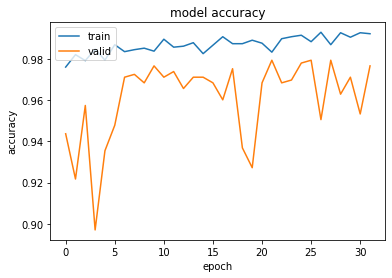

In [ ]:
# prints what the history has stored (stored in a dictionary format (key-value pairs))
print(history.history.keys())

# summarize history for accuracy on a line chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

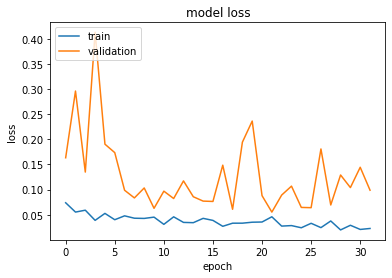

In [ ]:
# summarize history for loss on a line chart
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from keras.models import load_model #to load the model saved as a h5 file
# load model
densenet201_full_model = build_my_model(densenet201_pre_trained_model)

densenet201_full_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

densenet201_full_model.load_weights('densenet201_b16_bestweights.hdf5')
# summarize model.
densenet201_full_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              96338944  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for validation data - seed=42
test_generator = test_datagen.flow_from_directory('test',
                                              target_size= (224,224),
                                              batch_size = 1,
                                              shuffle = False,
                                              class_mode='categorical',
                                              classes = class_array)


Found 1214 images belonging to 3 classes.


In [ ]:
my_densenet201_model.evaluate(test_generator) # using model on testing dataset

1214/1214 [==============================] - 31s 25ms/step - loss: 0.1840 - accuracy: 0.9596


[0.1840304434299469, 0.9596375823020935]

In [ ]:
densenet201_full_model.evaluate(test_generator) # best weights

1214/1214 [==============================] - 35s 25ms/step - loss: 0.1319 - accuracy: 0.9809


[0.17634093761444092, 0.9703459739685059]

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix # ask parents

y_true = test_generator.classes
probabilities = my_densenet201_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       462
           1       0.97      0.99      0.98       258
           2       0.98      0.97      0.97       494

    accuracy                           0.97      1214
   macro avg       0.97      0.97      0.97      1214
weighted avg       0.97      0.97      0.97      1214

accuracy:  0.9703459637561779
[[446   6  10]
 [  1 255   2]
 [ 16   1 477]]


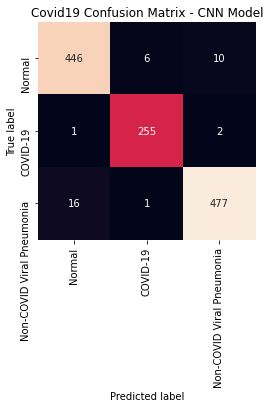

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

y_true = test_generator.classes
probabilities = densenet201_full_model.predict(test_generator)
y_pred = probabilities.argmax(axis = 1)
# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print('accuracy: ', accuracy)

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

cm_df = pd.DataFrame(conf_mat,
                     index = class_array,
                     columns = class_array)

plt.figure()
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Covid19 Confusion Matrix - CNN Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
!cp densenet201_b16_bestweights.hdf5 "/content/gdrive/MyDrive/Science Fair"
!cp my_densenet201_model_b16.h5 "/content/gdrive/MyDrive/Science Fair"

In [ ]:
!nvidia-smi

Mon Mar  1 07:09:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------